# Quantum Neural Networks

Based on [qiskit-tutorials](https://github.com/Qiskit/qiskit-tutorials) with minor modification by Rudy Raymond (rudyhar@jp.ibm.com).
Shared at the 36th JSAI on June 17, 2022 in Kyoto. 

---
This notebook demonstrates the different generic quantum neural network (QNN) implementations provided in Qiskit Machine Learning.
The networks are meant as application-agnostic computational units that can be used for many different use cases. 
Depending on the application, a particular type of network might more or less suitable and might require to be set up in a particular way.
The following different available neural networks will now be discussed in more detail:

1. `NeuralNetwork`: The interface for neural networks.
2. `OpflowQNN`: A network based on the evaluation of quantum mechanical observables.
3. `TwoLayerQNN`: A special `OpflowQNN` implementation for convenience. 
3. `CircuitQNN`: A network based on the samples resulting from measuring a quantum circuit.

In [1]:
import numpy as np

from qiskit import Aer, QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.opflow import StateFn, PauliSumOp, AerPauliExpectation, ListOp, Gradient
from qiskit.utils import QuantumInstance, algorithm_globals

algorithm_globals.random_seed = 42

In [2]:
# set method to calculcate expected values
expval = AerPauliExpectation()

# define gradient method
gradient = Gradient()

# define quantum instances (statevector and sample based)
qi_sv = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))

# we set shots to 10 as this will determine the number of samples later on.
qi_qasm = QuantumInstance(Aer.get_backend("aer_simulator"), shots=10)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## 1. `NeuralNetwork`

The `NeuralNetwork` represents the interface for all neural networks available in Qiskit Machine Learning.
It exposes a forward and a backward pass taking the data samples and trainable weights as input.
A `NeuralNetwork` does not contain any training capabilities, these are pushed to the actual algorithms / applications. Thus, a `NeuralNetwork` also does not store the values for trainable weights. In the following, different implementations of this interfaces are introduced.

Suppose a `NeuralNetwork` called `nn`.
Then, the `nn.forward(input, weights)` pass takes either flat inputs for the data and weights of size `nn.num_inputs` and `nn.num_weights`, respectively.
`NeuralNetwork` supports batching of inputs and returns batches of output of the corresponding shape.

## 2. `OpflowQNN`

The `OpflowQNN` takes a (parametrized) operator from Qiskit and leverages Qiskit's gradient framework to provide the backward pass. 
Such an operator can for instance be an expected value of a quantum mechanical observable with respect to a parametrized quantum state. The Parameters can be used to load classical data as well as represent trainable weights.
The `OpflowQNN` also allows lists of operators and more complex structures to construct more complex QNNs.

In [3]:
from qiskit_machine_learning.neural_networks import OpflowQNN

In [4]:
# construct parametrized circuit
params1 = [Parameter("input1"), Parameter("weight1")]
qc1 = QuantumCircuit(1)
qc1.h(0)
qc1.ry(params1[0], 0)
qc1.rx(params1[1], 0)
qc_sfn1 = StateFn(qc1)

# construct cost operator
H1 = StateFn(PauliSumOp.from_list([("Z", 1.0), ("X", 1.0)]))

# combine operator and circuit to objective function
op1 = ~H1 @ qc_sfn1
print(op1)

ComposedOp([
  OperatorMeasurement(1.0 * Z
  + 1.0 * X),
  CircuitStateFn(
     ┌───┐┌────────────┐┌─────────────┐
  q: ┤ H ├┤ Ry(input1) ├┤ Rx(weight1) ├
     └───┘└────────────┘└─────────────┘
  )
])


In [5]:
# construct OpflowQNN with the operator, the input parameters, the weight parameters,
# the expected value, gradient, and quantum instance.
qnn1 = OpflowQNN(op1, [params1[0]], [params1[1]], expval, gradient, qi_sv)

In [6]:
# define (random) input and weights
input1 = algorithm_globals.random.random(qnn1.num_inputs)
weights1 = algorithm_globals.random.random(qnn1.num_weights)

In [7]:
# QNN forward pass
qnn1.forward(input1, weights1)

array([[0.08242345]])

In [8]:
# QNN batched forward pass
qnn1.forward([input1, input1], weights1)

array([[0.08242345],
       [0.08242345]])

In [9]:
# QNN backward pass
qnn1.backward(input1, weights1)

(None, array([[[0.2970094]]]))

In [10]:
# QNN batched backward pass
qnn1.backward([input1, input1], weights1)

(None,
 array([[[0.2970094]],
 
        [[0.2970094]]]))

Combining multiple observables in a `ListOp` also allows to create more complex QNNs

In [11]:
op2 = ListOp([op1, op1])
qnn2 = OpflowQNN(op2, [params1[0]], [params1[1]], expval, gradient, qi_sv)

In [12]:
# QNN forward pass
qnn2.forward(input1, weights1)

array([[0.08242345, 0.08242345]])

In [13]:
# QNN backward pass
qnn2.backward(input1, weights1)

(None,
 array([[[0.2970094],
         [0.2970094]]]))

## 3. `TwoLayerQNN`

The `TwoLayerQNN` is a special `OpflowQNN` on $n$ qubits that consists of first a feature map to insert data and second an ansatz that is trained. The default observable is $Z^{\otimes n}$, i.e., parity.

In [14]:
from qiskit_machine_learning.neural_networks import TwoLayerQNN

In [15]:
# specify the number of qubits
num_qubits = 3

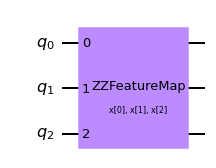

In [17]:
# specify the feature map
fm = ZZFeatureMap(num_qubits, reps=2)
fm.draw(output="mpl")

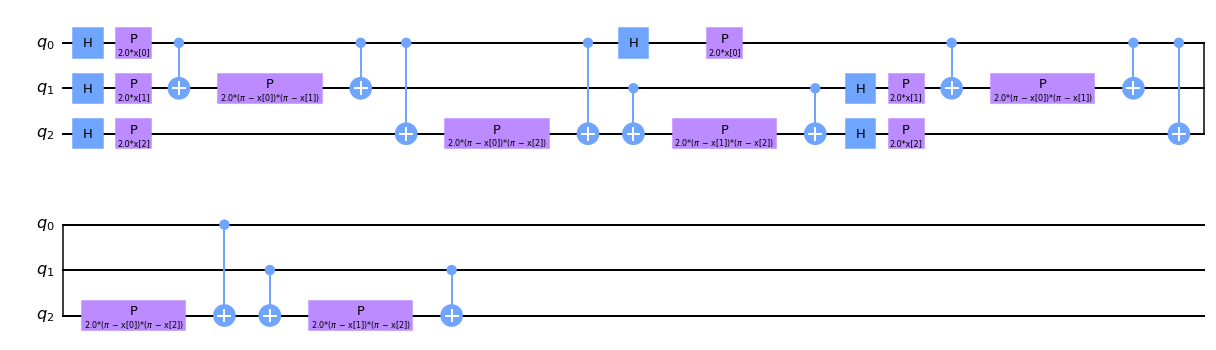

In [19]:
fm.decompose().draw(output="mpl")

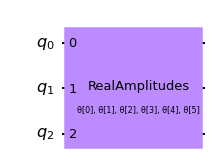

In [20]:
# specify the ansatz
ansatz = RealAmplitudes(num_qubits, reps=1)
ansatz.draw(output="mpl")

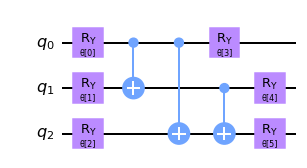

In [21]:
ansatz.decompose().draw(output="mpl")

In [22]:
# specify the observable
observable = PauliSumOp.from_list([("Z" * num_qubits, 1)])
print(observable)

1.0 * ZZZ


In [23]:
# define two layer QNN
qnn3 = TwoLayerQNN(
    num_qubits, feature_map=fm, ansatz=ansatz, observable=observable, quantum_instance=qi_sv
)

In [24]:
# define (random) input and weights
input3 = algorithm_globals.random.random(qnn3.num_inputs)
weights3 = algorithm_globals.random.random(qnn3.num_weights)

In [25]:
# QNN forward pass
qnn3.forward(input3, weights3)

array([[0.18276559]])

In [26]:
# QNN backward pass
qnn3.backward(input3, weights3)

(None,
 array([[[ 0.10231208,  0.10656571,  0.41017902,  0.16528909,
          -0.27780262,  0.41365763]]]))

## 4. `CircuitQNN`

The `CircuitQNN` is based on a (parametrized) `QuantumCircuit`.
This can take input as well as weight parameters and produces samples from the measurement. The samples can either be interpreted as probabilities of measuring the integer index corresponding to a bitstring or directly as a batch of binary output. In the case of probabilities, gradients can be estimated efficiently and the `CircuitQNN` provides a backward pass as well. In case of samples, differentiation is not possible and the backward pass returns `(None, None)`.

Further, the `CircuitQNN` allows to specify an `interpret` function to post-process the samples. This is expected to take a measured integer (from a bitstring) and map it to a new index, i.e. non-negative integer. In this case, the output shape needs to be provided and the probabilities are aggregated accordingly.

A `CircuitQNN` can be configured to return sparse as well as dense probability vectors. If no `interpret` function is used, the dimension of the probability vector scales exponentially with the number of qubits and a sparse recommendation is usually recommended. In case of an `interpret` function it depends on the expected outcome. If, for instance, an index is mapped to the parity of the corresponding bitstring, i.e., to 0 or 1, a dense output makes sense and the result will be a probability vector of length 2.

In [27]:
from qiskit_machine_learning.neural_networks import CircuitQNN

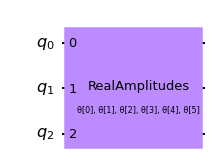

In [28]:
qc = RealAmplitudes(num_qubits, entanglement="linear", reps=1)
qc.draw(output="mpl")

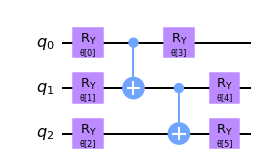

In [29]:
qc.decompose().draw(output="mpl")

### 4.1 Output: sparse integer probabilities

In [31]:
# specify circuit QNN
qnn4 = CircuitQNN(qc, [], qc.parameters, sparse=False, quantum_instance=qi_qasm)

In [32]:
# define (random) input and weights
input4 = algorithm_globals.random.random(qnn4.num_inputs)
weights4 = algorithm_globals.random.random(qnn4.num_weights)

In [34]:
# QNN forward pass
qnn4.forward(input4, weights4)  # returned as a sparse matrix

array([[0.4, 0. , 0. , 0. , 0.2, 0.2, 0.1, 0.1]])

In [35]:
# QNN backward pass, returns a tuple of sparse matrices
qnn4.backward(input4, weights4)

(None,
 array([[[-0.2 , -0.25, -0.45, -0.05, -0.15, -0.3 ],
         [ 0.  ,  0.1 ,  0.  , -0.15,  0.  , -0.05],
         [ 0.  ,  0.  ,  0.  ,  0.  , -0.05,  0.  ],
         [ 0.  ,  0.  ,  0.  ,  0.  ,  0.05, -0.15],
         [-0.15, -0.2 ,  0.45,  0.  ,  0.  ,  0.25],
         [ 0.  ,  0.  ,  0.05,  0.2 ,  0.05,  0.2 ],
         [-0.1 ,  0.15,  0.  , -0.15,  0.05,  0.  ],
         [ 0.45,  0.2 , -0.05,  0.15,  0.05,  0.05]]]))

### 4.2 Output: dense parity probabilities

In [36]:
# specify circuit QNN
parity = lambda x: "{:b}".format(x).count("1") % 2
output_shape = 2  # this is required in case of a callable with dense output
qnn6 = CircuitQNN(
    qc,
    [],
    qc.parameters,
    sparse=False,
    interpret=parity,
    output_shape=output_shape,
    quantum_instance=qi_qasm,
)

In [37]:
# define (random) input and weights
input6 = algorithm_globals.random.random(qnn6.num_inputs)
weights6 = algorithm_globals.random.random(qnn6.num_weights)

In [38]:
# QNN forward pass
qnn6.forward(input6, weights6)

array([[0.6, 0.4]])

In [39]:
# QNN backward pass
qnn6.backward(input6, weights6)

(None,
 array([[[-0.25,  0.25, -0.3 , -0.05,  0.05, -0.2 ],
         [ 0.25, -0.25,  0.3 ,  0.05, -0.05,  0.2 ]]]))

### 4.3 Output: Samples

In [40]:
# specify circuit QNN
qnn7 = CircuitQNN(qc, [], qc.parameters, sampling=True, quantum_instance=qi_qasm)

In [41]:
# define (random) input and weights
input7 = algorithm_globals.random.random(qnn7.num_inputs)
weights7 = algorithm_globals.random.random(qnn7.num_weights)

In [42]:
# QNN forward pass, results in samples of measured bit strings mapped to integers
qnn7.forward(input7, weights7)

array([[[1.],
        [0.],
        [7.],
        [1.],
        [7.],
        [0.],
        [7.],
        [0.],
        [0.],
        [7.]]])

In [43]:
# QNN backward pass
qnn7.backward(input7, weights7)

(None, None)

### 4.4 Output: Parity Samples

In [44]:
# specify circuit QNN
qnn8 = CircuitQNN(qc, [], qc.parameters, sampling=True, interpret=parity, quantum_instance=qi_qasm)

In [45]:
# define (random) input and weights
input8 = algorithm_globals.random.random(qnn8.num_inputs)
weights8 = algorithm_globals.random.random(qnn8.num_weights)

In [46]:
# QNN forward pass, results in samples of measured bit strings
qnn8.forward(input8, weights8)

array([[[1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.]]])

In [47]:
# QNN backward pass
qnn8.backward(input8, weights8)

(None, None)

In [48]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright